In [1]:
import numpy as np
from scipy.linalg import eigvals
from scipy.integrate import solve_ivp
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable, AxesGrid
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
MU = 3.986e+14                                 # [m^3 / s^2] standard gravitational parameter of the Earth
MU_0 = 1.257e-6                                # [N / A^2] vacuum permeability
MU_e = 7.94e+22                                # [A * m^2] magnetic dipole moment of the Earth

R_e = 6371e+3                                  # [m] radius of the Earth
altitude = 750e+3                              # [m] altitude of the orbit
incl = np.pi / 3.                              # [rad] inclination of the orbit

R_orb = R_e + altitude                         # [m] radius of the orbit
omega_0 = np.sqrt(MU / R_orb**3.)              # [rad / s] angular velocity on the orbit

J = np.diag(np.array([0.009, 0.011, 0.014]))   # [kg * m^2] inertia tensor for satellite
B_0 = MU_e * MU_0 / (4 * np.pi * R_orb**3.)    # [T] magnitude of the magnetic field  on the orbit

def B_orb(u, i = incl):
    
    """
    B(latitude, inclination) -- magnetic field on the orbit
    :param u: latitude in degrees
    :param i: inclination in degrees (60 by default)
    :returns: 3-axis magnetic field
    """
    
    return B_0 * np.array([np.cos(u)*np.sin(i), np.cos(i), -2.*np.sin(u)*np.sin(i)])

def skew_symm(vec):
        
    return np.array([[0., -vec[2], vec[1]],[vec[2], 0., -vec[0]],[-vec[1], vec[0], 0.]])

In [3]:
def Jacobian(u, kw, Ks, omega_orb, J_sat):
    
    J_inv = np.linalg.inv(J_sat)
    W = skew_symm(B_orb(u))
    
    dJ_sym = J_sat[1,1] - J_sat[0,0] - J_sat[2,2]
    DJ_sym = np.array([[0, 0, dJ_sym], [0, 0, 0], [-dJ_sym, 0, 0]])
    dJ12 = J_sat[1,1] - J_sat[2,2]
    dJ20 = J_sat[2,2] - J_sat[0,0]
    dJ01 = J_sat[0,0] - J_sat[1,1]
    DJ_tr = np.array([[-4 * dJ12, 0, 0], [0, 3 * dJ20, 0], [0, 0, dJ01]])
    
    A1 = J_inv @ (kw / omega_orb**2 * W @ W + DJ_sym)
    A2 = J_inv @ (2 * Ks / omega_orb**2 * W @ W + DJ_tr)
    A3 = np.eye(3)
    A4 = np.zeros((3, 3))
    
    return np.vstack((np.hstack((A1, A2)), np.hstack((A3, A4))))

def monodromy_array(kw, Ks, omega_orb, J_sat):
    
    def fun(u, x):
        
        return Jacobian(u, kw, Ks, omega_orb, J_sat).dot(x.reshape((6,6))).flatten()
    
    flat_mdrm = solve_ivp(fun, (0, 2 * np.pi), np.identity(6).flatten()).y[:,-1]
    return flat_mdrm.reshape((6,6))

def coef_distribution(K, **kwargs):
    
    kw, Ks = K
    
    return np.max(np.real(np.log(eigvals(monodromy_array(kw, Ks, kwargs['omega_orb'], kwargs['J_sat'])))))

In [4]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [5]:
def plot_coefficients(N1, N2, dN, n, omega_0, J):
    
    x = np.linspace(N1, N1+dN, n)
    X = np.repeat([x], n, axis=0)
    y = np.linspace(N2+dN, N2, n)
    Y = np.transpose(np.repeat([y], n, axis=0))

    f_points = np.dstack((X, Y))

    Z = np.apply_along_axis(coef_distribution, -1, f_points, omega_orb=omega_0, J_sat=J)
    Z_max = np.max(Z)
    Z_min = np.min(Z)
    i,j = np.where(Z == Z_min)
    
    mid = 1 - Z_max / (Z_max + abs(Z_min))

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    shifted_cmap = shiftedColorMap(matplotlib.cm.coolwarm, midpoint=mid, name='shifted')
    im = ax.imshow(Z, interpolation='spline36', cmap=shifted_cmap, extent=[N1, N1+dN, N2, N2+dN])
    ax.set_title('Coefficients: $k_w = $%5.2f, $K_s = $%5.2f' % (f_points[i,j,0], f_points[i,j,1]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

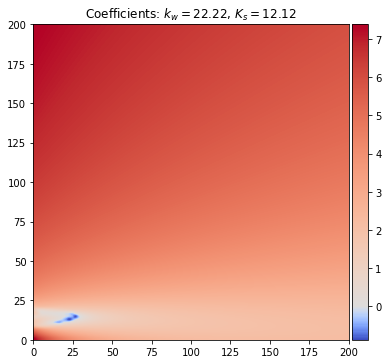

In [6]:
N1 = 0
N2 = 0
dN = 200
n = 100

plot_coefficients(N1, N2, dN, n, omega_0, J)

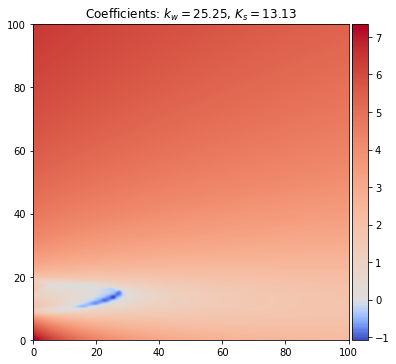

In [7]:
N1 = 0
N2 = 0
dN = 100
n = 100

plot_coefficients(N1, N2, dN, n, omega_0, J)

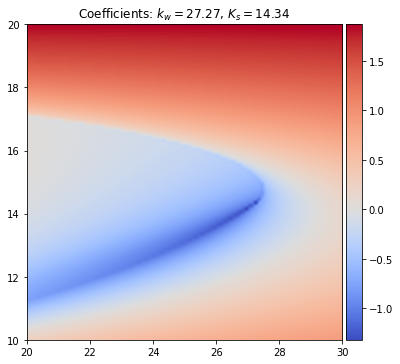

In [8]:
N1 = 20
N2 = 10
dN = 10
n = 100

plot_coefficients(N1, N2, dN, n, omega_0, J)